### Формирование модели машинного обучения

Текущий ноутбук рассматривает анализ датасета [Palmer Archipelago (Antarctica) penguin data](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data).

В работе рассматривается:
1. обучение регрессионной модели для классифицирования вида пингвина на основе всех остальных признаков;
2. сохранение обученной модели в виде **конвейера обработки данных** для последующего использования.

In [1]:
import pandas as pd
from seaborn import pairplot
from pickle import dump
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
col_names = ("species", "island", "culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", 
             "body_mass_g", "sex")
df = pd.read_csv("../data/penguins_size.csv")

In [3]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Часть столбцов имеют не числовые данные - преобразуем

In [5]:
#Получаем информацию о нулевых значениях в колонках
df.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [6]:
#Очищаем пустые значения
df.dropna(how="any", inplace=True)

In [7]:
#Посмотрим соотношение количества пингвинов разных полов
df["sex"].value_counts()

MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64

In [8]:
#Уберём значение с точкой из статистики
df = df[df["sex"] != "."]
df["sex"].value_counts()

MALE      168
FEMALE    165
Name: sex, dtype: int64

In [9]:
df["sex"] = df["sex"].map({
    "MALE": 0, "FEMALE": 1
})

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   culmen_length_mm   333 non-null    float64
 3   culmen_depth_mm    333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 20.8+ KB


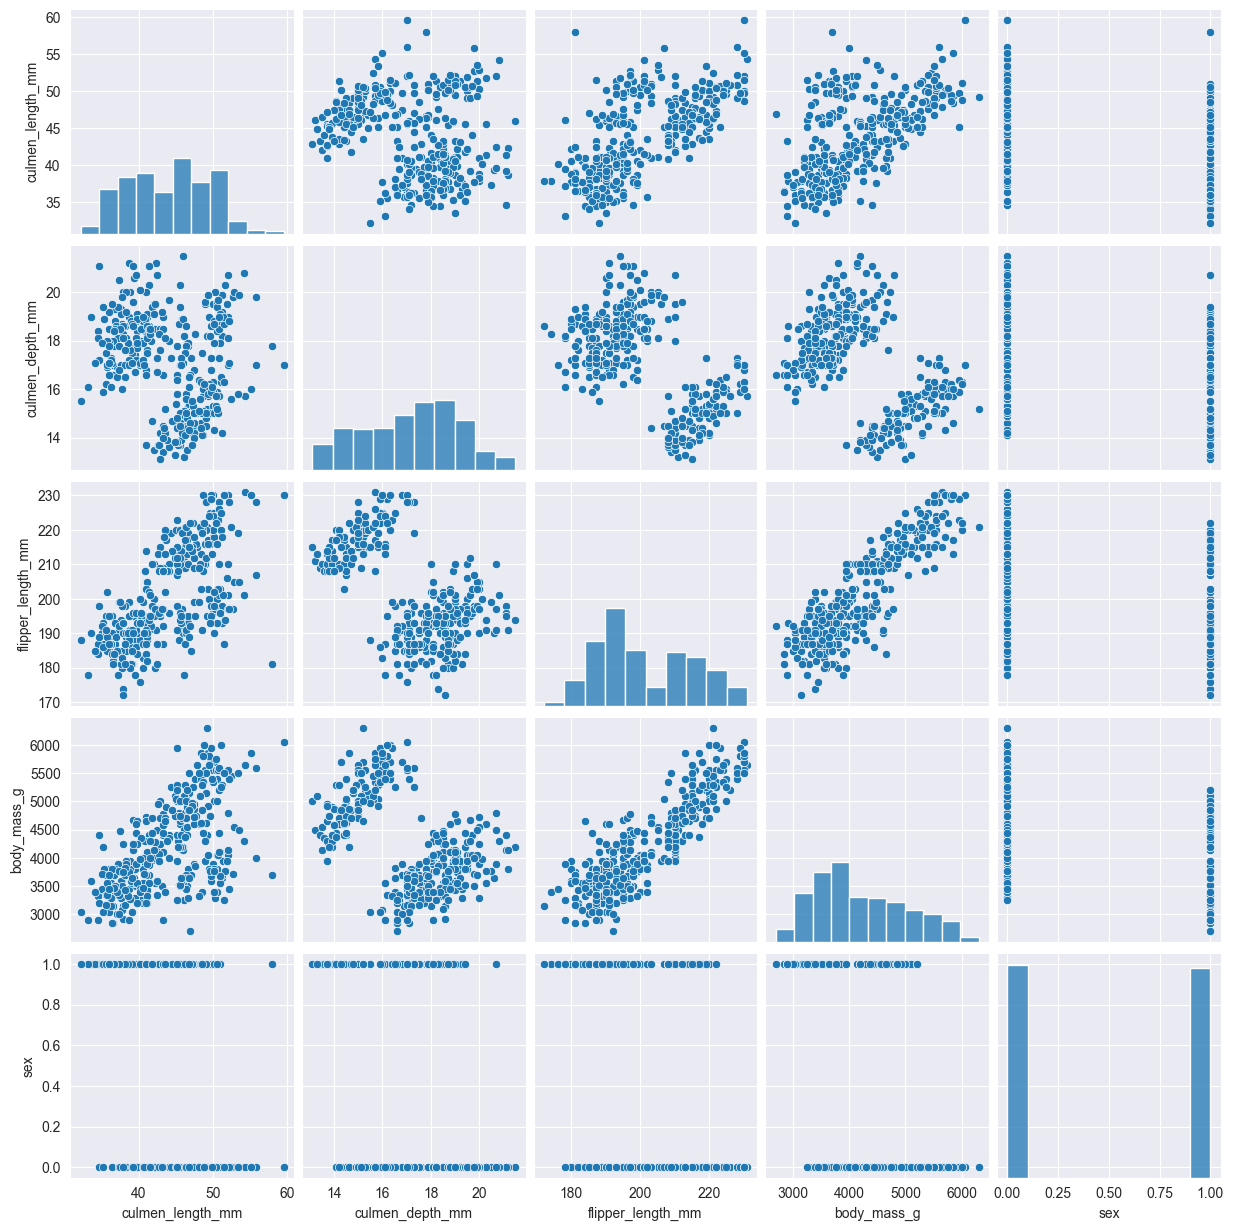

In [11]:
pairplot(df)

Посмотрим на распределение категориальных переменных.

In [12]:
df["species"].value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

In [13]:
df["island"].value_counts()

Biscoe       163
Dream        123
Torgersen     47
Name: island, dtype: int64

Выясним, содержатся ли выбросы в данных.

<Axes: >

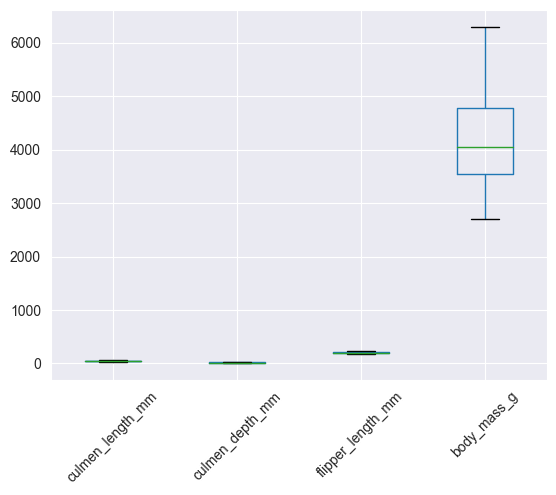

In [14]:
df[["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", 
             "body_mass_g"]].boxplot(rot=45)

In [15]:
df = pd.get_dummies(df, columns=['island'], drop_first= False, dtype="int64")

In [16]:
X = df.drop("species", axis=1)
Y = df["species"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [17]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [18]:
y_pred = dt.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9701492537313433

Сохраним полученный конвейер обработки данных для дальнейшего использования.

In [19]:
Path("../models").mkdir(parents=True, exist_ok=True)

with open("../models/pipeline.pkl", "wb") as file:
    dump(dt, file)

In [20]:
X_test

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,island_Biscoe,island_Dream,island_Torgersen
222,48.7,14.1,210.0,4450.0,1,1,0,0
314,44.5,14.7,214.0,4850.0,1,1,0,0
242,46.5,14.5,213.0,4400.0,1,1,0,0
182,40.9,16.6,187.0,3200.0,1,0,1,0
173,48.5,17.5,191.0,3400.0,0,0,1,0
...,...,...,...,...,...,...,...,...
266,45.5,13.9,210.0,4200.0,1,1,0,0
163,51.7,20.3,194.0,3775.0,0,0,1,0
188,47.6,18.3,195.0,3850.0,1,0,1,0
44,37.0,16.9,185.0,3000.0,1,0,1,0
